In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
## Precipitation

In [10]:
# Get date range for last 12 months of data

# Query for last date in table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# first_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=366)

# Get date into string format, convert to datetime object, calculate start date
last_date = np.ravel(last_date)[0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
first_date = last_date - dt.timedelta(days=366)
first_date, last_date

(datetime.datetime(2016, 8, 22, 0, 0), datetime.datetime(2017, 8, 23, 0, 0))

In [11]:
# Perform a query to retrieve the data and precipitation scores for the last 12 months of data
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > first_date).all()
precipitation[0:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column & sort by date
precip = pd.DataFrame(precipitation)
precip.sort_values(by = 'date', inplace=True)
precip.set_index('date', inplace=True)

In [13]:
print(precip.shape)
precip.tail()

(2230, 1)


,prcp
date,
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45


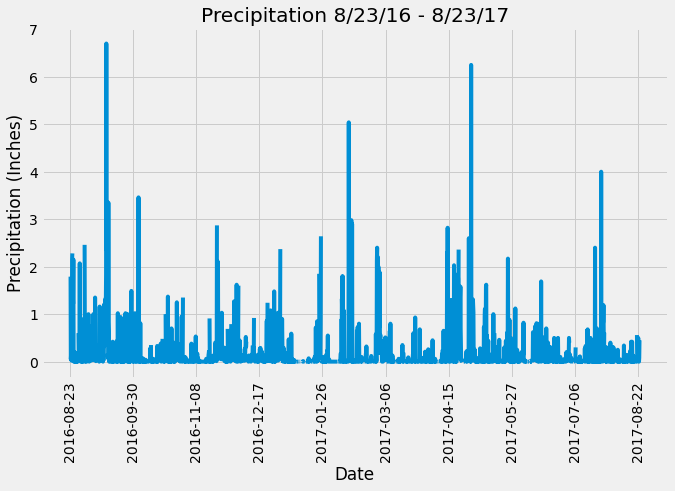

In [14]:
# Plot precipitation results
xticks = np.arange(0,len(precip.index),(int(len(precip.index)/9))).tolist()
xlabels = []
for location in xticks:
    date = precip.index[location]
    xlabels.append(date)

precip.plot(figsize = (10,6), legend = None)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(xticks, xlabels, rotation = 90)
plt.title('Precipitation 8/23/16 - 8/23/17')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Stations

In [16]:
# Query to show how many stations are available in this dataset
station_count = session.query(Measurement).group_by('station').count()
print(f'Station Count: {station_count}')

Station Count: 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).\
                              group_by(Measurement.station).\
                              order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
min_temp = session.query(func.min(Measurement.tobs)).filter_by(station = 'USC00519281').all()
max_temp = session.query(func.max(Measurement.tobs)).filter_by(station = 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter_by(station = 'USC00519281').all()

print(f'Min Temp: {min_temp[0][0]}\nMax Temp: {max_temp[0][0]}\nAvg Temp: {round(avg_temp[0][0],1)}')

Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.7


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
year_data = session.query(Measurement.date, Measurement.tobs).\
                        filter_by(station = 'USC00519281').\
                        filter(Measurement.date > first_date).all()
year_data[0:5]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0)]

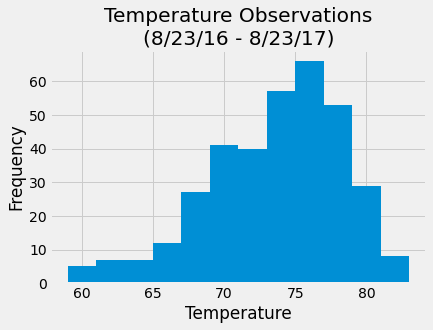

In [20]:
# plot the results as a histogram
x_axis = [temp[1] for temp in year_data]
plt.hist(x_axis, bins=12)
plt.title('Temperature Observations\n(8/23/16 - 8/23/17)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-09-12'
trip_end = '2016-09-22'
trip_temps = calc_temps(trip_start, trip_end)

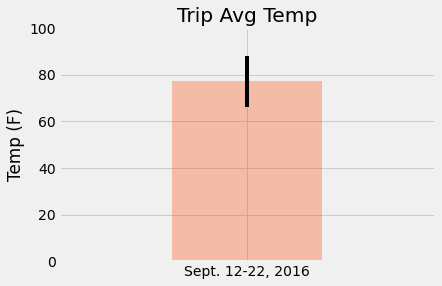

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = trip_temps[0][0]
tave = trip_temps[0][1]
tmax = trip_temps[0][2]
tmin, tave, tmax

yerr = tmax-tmin

plt.bar('Sept. 12-22, 2016',tave, color = 'orangered', alpha = .3, yerr = tmax-tmin)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xlim(-1,1)
plt.ylim(0,100)
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates,
#   using the previous year's matching dates.

# Sort this in descending order by precipitation amount
columns = [Measurement.station, Measurement.date, Measurement.prcp, Station.station, Station.name,
      Station.latitude, Station.longitude, Station.elevation]
join = session.query(*columns).filter(Measurement.station == Station.station).all()

rain = session.query(Measurement.station, func.sum(Measurement.prcp)).\
                    filter(Measurement.date >= '2016-09-12').\
                    filter(Measurement.date <= '2016-09-22').\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()
rain

[('USC00516128', 16.0),
 ('USC00519281', 4.94),
 ('USC00514830', 2.7399999999999998),
 ('USC00519523', 2.119999999999999),
 ('USC00519397', 1.8900000000000001),
 ('USC00513117', 1.7300000000000004),
 ('USC00517948', 0.06)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
start_date = dt.datetime.strptime(trip_start, '%Y-%m-%d')
end_date = dt.datetime.strptime(trip_end, '%Y-%m-%d')
next_day = dt.timedelta(days=1)

date_range = []
while start_date <= end_date:
    date_range.append(dt.datetime.strftime(start_date.date(), '%m-%d'))
    start_date += next_day
date_range

['09-12',
 '09-13',
 '09-14',
 '09-15',
 '09-16',
 '09-17',
 '09-18',
 '09-19',
 '09-20',
 '09-21',
 '09-22']

In [27]:
# Loop through the list of %m-%d strings and calculate the normals for each date
norm_min = []
norm_avg = []
norm_max = []
for date in date_range:
    norm_min.append(daily_normals(date)[0][0])
    norm_avg.append(daily_normals(date)[0][1])
    norm_max.append(daily_normals(date)[0][2])
norm_min

[68.0, 68.0, 69.0, 67.0, 70.0, 68.0, 67.0, 68.0, 69.0, 67.0, 69.0]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates`
#   range as the `date` index
df = pd.DataFrame({'Min': norm_min, 'Avg': norm_avg, 'Max': norm_max}, index = date_range)
df

,Min,Avg,Max
09-12,68.0,75.897959,85.0
09-13,68.0,75.875000,82.0
09-14,69.0,75.980769,85.0
09-15,67.0,76.140000,81.0
09-16,70.0,77.403846,86.0
09-17,68.0,76.576923,83.0
09-18,67.0,75.851064,84.0
09-19,68.0,76.346939,87.0
09-20,69.0,76.145833,83.0
09-21,67.0,76.448980,84.0


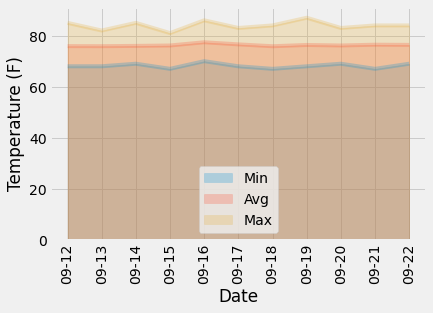

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked = False, alpha=.25)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
xticks = np.arange(0,len(df.index))
plt.xticks(xticks, df.index, rotation = 'vertical')
plt.legend(loc = 'lower center')
plt.show()